Procesando: Social: Karate Club | Nodos: 34 | Aristas: 78
Procesando: Social: Florentine Families | Nodos: 15 | Aristas: 20
Procesando: Social: Davis Women | Nodos: 32 | Aristas: 205
Procesando: Mapa: Grid 20x20 | Nodos: 400 | Aristas: 760
Procesando: Mapa: Geo Threshold | Nodos: 200 | Aristas: 7233
Procesando: Sintético: Erdős-Rényi | Nodos: 500 | Aristas: 12575
Procesando: Sintético: Barabási-Albert | Nodos: 300 | Aristas: 596
Procesando: Sintético: Watts-Strogatz | Nodos: 200 | Aristas: 400

=== RESULTADOS EXPERIMENTALES (Sección 10 del Paper) ===
                        Dataset     Algoritmo  Tiempo Promedio (s)  \
0           Social: Karate Club      Dijkstra             0.000459   
1           Social: Karate Club  Bellman-Ford             0.000916   
2           Social: Karate Club           BFS             0.000220   
3   Social: Florentine Families      Dijkstra             0.000127   
4   Social: Florentine Families  Bellman-Ford             0.000330   
5   Social: Florentine 

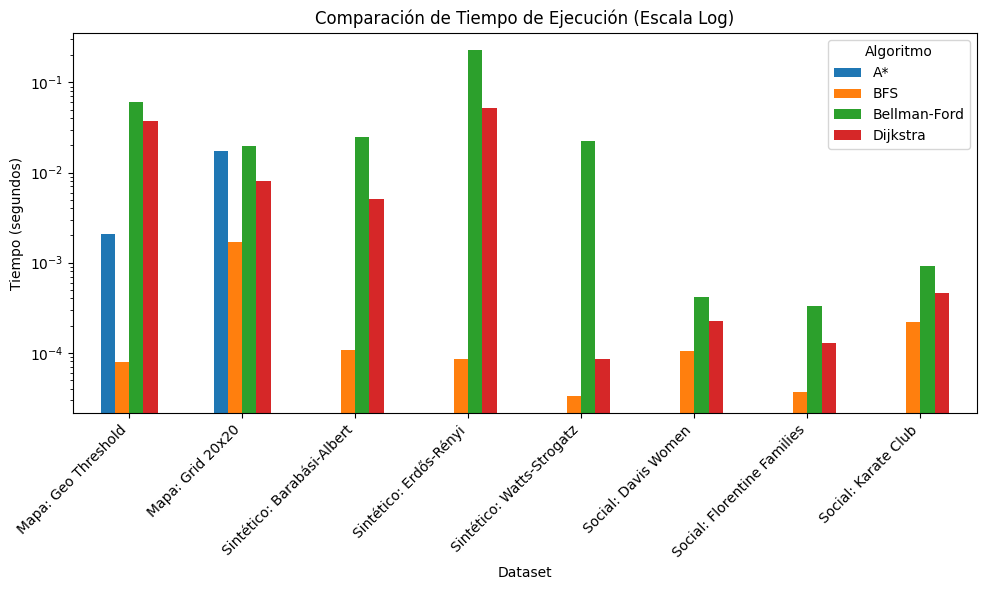

In [ ]:
import networkx as nx
import time
import tracemalloc
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# Configuración de reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

def get_graph_datasets():
    """
    Genera los conjuntos de datos definidos en la Sección 10.2 del paper.
    """
    graphs = []

    # --- 1. Redes Sociales (NetworkX) [cite: 176-179] ---
    # Nota: Davis Southern Women es un grafo bipartito, lo proyectamos para SSSP
    davis = nx.davis_southern_women_graph()
    davis_projected = nx.bipartite.projected_graph(davis, davis.nodes())

    graphs.append(("Social: Karate Club", nx.karate_club_graph()))
    graphs.append(("Social: Florentine Families", nx.florentine_families_graph()))
    graphs.append(("Social: Davis Women", davis_projected))

    # --- 2. Mapas Sintéticos (Con Coordenadas) [cite: 181-186] ---
    # Grid 20x20
    G_grid = nx.grid_2d_graph(20, 20)
    # Asignar pesos euclidianos (en grid es 1, pero lo formalizamos)
    for u, v in G_grid.edges():
        G_grid[u][v]['weight'] = 1.0
        # Grid 2d ya tiene pos implícita en los nombres de nodos, pero la hacemos explícita para A*
        G_grid.nodes[u]['pos'] = u
        G_grid.nodes[v]['pos'] = v
    graphs.append(("Mapa: Grid 20x20", G_grid))

    # Grafo Geométrico Aleatorio (aprox similar al threshold graph mencionado)
    G_geo = nx.geographical_threshold_graph(200, 10, seed=SEED) # Ajustado n=200 para prueba
    # Asignar pesos euclidianos basados en posición
    for u, v in G_geo.edges():
        pos_u = G_geo.nodes[u]['pos']
        pos_v = G_geo.nodes[v]['pos']
        dist = ((pos_u[0]-pos_v[0])**2 + (pos_u[1]-pos_v[1])**2)**0.5
        G_geo[u][v]['weight'] = dist
    graphs.append(("Mapa: Geo Threshold", G_geo))

    # --- 3. Grafos Aleatorios Sintéticos [cite: 187-194] ---
    # Erdős-Rényi (n=500, p=0.1)
    G_er = nx.erdos_renyi_graph(500, 0.1, seed=SEED, directed=False)
    for u, v in G_er.edges(): G_er[u][v]['weight'] = random.random()
    graphs.append(("Sintético: Erdős-Rényi", G_er))

    # Barabási-Albert (n=300, m=2)
    G_ba = nx.barabasi_albert_graph(300, 2, seed=SEED)
    for u, v in G_ba.edges(): G_ba[u][v]['weight'] = random.random()
    graphs.append(("Sintético: Barabási-Albert", G_ba))

    # Watts-Strogatz (n=200, k=4, p=0.3)
    G_ws = nx.watts_strogatz_graph(200, 4, 0.3, seed=SEED)
    for u, v in G_ws.edges(): G_ws[u][v]['weight'] = random.random()
    graphs.append(("Sintético: Watts-Strogatz", G_ws))

    return graphs

def run_experiment(graphs, num_runs=10):
    """
    Ejecuta Dijkstra, Bellman-Ford, BFS y A* según Sección 10.1 y 10.4.
    """
    results = []

    for name, G in graphs:
        print(f"Procesando: {name} | Nodos: {len(G.nodes)} | Aristas: {len(G.edges)}")

        # Asegurar que el grafo sea dirigido para el experimento general (Dijkstra/Bellman suelen usarse así)
        # O mantener no dirigido según la definición del dataset. NetworkX maneja ambos.
        # Seleccionamos nodo origen aleatorio
        source = list(G.nodes())[0]
        target = list(G.nodes())[-1] # Un destino arbitrario para A*

        algorithms = [
            ("Dijkstra", nx.dijkstra_path),
            ("Bellman-Ford", nx.bellman_ford_path),
            ("BFS", nx.shortest_path), # BFS en nx es shortest_path sin pesos
        ]

        # A* solo si tiene coordenadas
        has_pos = nx.get_node_attributes(G, 'pos')
        if has_pos:
            algorithms.append(("A*", nx.astar_path))

        for alg_name, alg_func in algorithms:
            times = []
            mems = []

            # Repetir 10 veces
            for _ in range(num_runs):
                tracemalloc.start()
                start_time = time.perf_counter()

                try:
                    if alg_name == "BFS":
                        # BFS ignora pesos
                        alg_func(G, source, target)
                    elif alg_name == "A*":
                        # Heurística Euclideana
                        def euclidean(a, b):
                            (x1, y1) = G.nodes[a]['pos']
                            (x2, y2) = G.nodes[b]['pos']
                            return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
                        alg_func(G, source, target, heuristic=euclidean, weight='weight')
                    else:
                        # Dijkstra y Bellman-Ford usan pesos
                        alg_func(G, source, target, weight='weight')

                except nx.NetworkXNoPath:
                    pass # Camino no encontrado
                except Exception as e:
                    print(f"Error en {alg_name}: {e}")

                end_time = time.perf_counter()
                current, peak = tracemalloc.get_traced_memory()
                tracemalloc.stop()

                times.append(end_time - start_time)
                mems.append(peak / 1024**2) # Convertir a MB

            # Guardar promedio
            results.append({
                "Dataset": name,
                "Algoritmo": alg_name,
                "Tiempo Promedio (s)": np.mean(times),
                "Memoria Pico (MB)": np.mean(mems),
                "Nodos": len(G.nodes),
                "Aristas": len(G.edges)
            })

    return pd.DataFrame(results)

# --- Ejecución Principal ---
datasets = get_graph_datasets()
df_resultados = run_experiment(datasets)

# Mostrar resultados en tabla
print("\n=== RESULTADOS EXPERIMENTALES (Sección 10 del Paper) ===")
print(df_resultados)

# Opcional: Visualización rápida
pivot_df = df_resultados.pivot(index="Dataset", columns="Algoritmo", values="Tiempo Promedio (s)")
pivot_df.plot(kind='bar', figsize=(10, 6), logy=True) # Escala logarítmica por diferencias grandes
plt.title("Comparación de Tiempo de Ejecución (Escala Log)")
plt.ylabel("Tiempo (segundos)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
print()

Iniciando Test de Escalabilidad...


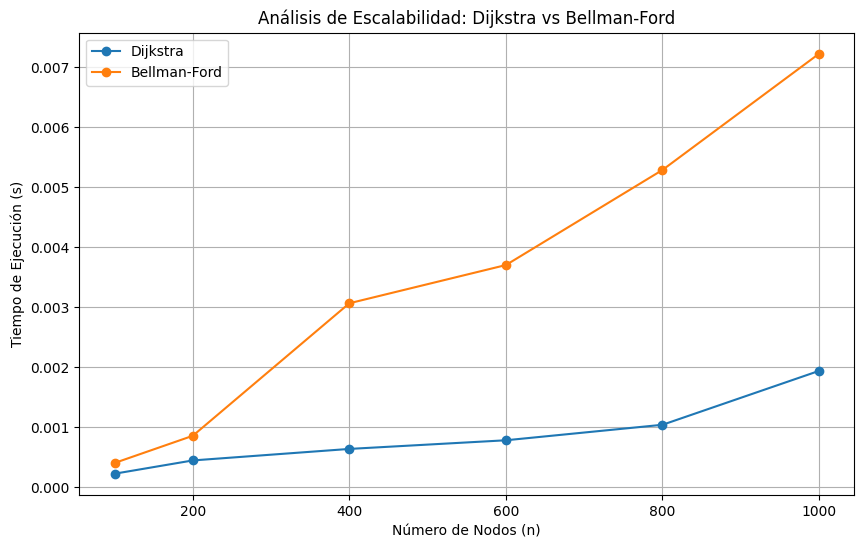

In [ ]:
def run_scalability_test():
    """
    Genera datos para evaluar la escalabilidad (Objetivo Específico 1 y 2)
    Variando el tamaño N del grafo para ver cómo se comportan las curvas.
    """
    sizes = [100, 200, 400, 600, 800, 1000] # Tamaños crecientes
    results = []

    print("Iniciando Test de Escalabilidad...")

    for n in sizes:
        # Generamos un grafo tipo Erdős-Rényi para cada tamaño
        # Mantenemos densidad constante para que sea justa la comparación
        m = n * 5  # Aprox 5 aristas por nodo
        p = m / (n * (n - 1))
        G = nx.erdos_renyi_graph(n, p, seed=SEED, directed=True) # Dirigido como pide el paper

        # Pesos aleatorios
        for u, v in G.edges():
            G[u][v]['weight'] = random.random()

        source = 0
        target = n - 1

        # Algoritmos a comparar en escalabilidad
        algs = [
            ("Dijkstra", nx.dijkstra_path),
            ("Bellman-Ford", nx.bellman_ford_path)
        ]

        for name, func in algs:
            times = []
            for _ in range(5): # 5 ejecuciones para este test
                start = time.perf_counter()
                try:
                    func(G, source, target, weight='weight')
                except:
                    pass
                times.append(time.perf_counter() - start)

            results.append({
                "Nodos": n,
                "Algoritmo": name,
                "Tiempo (s)": np.mean(times)
            })

    return pd.DataFrame(results)

# --- Ejecutar y Graficar Escalabilidad ---
df_scale = run_scalability_test()

plt.figure(figsize=(10, 6))
for alg in df_scale["Algoritmo"].unique():
    subset = df_scale[df_scale["Algoritmo"] == alg]
    plt.plot(subset["Nodos"], subset["Tiempo (s)"], marker='o', label=alg)

plt.title("Análisis de Escalabilidad: Dijkstra vs Bellman-Ford")
plt.xlabel("Número de Nodos (n)")
plt.ylabel("Tiempo de Ejecución (s)")
plt.legend()
plt.grid(True)
plt.show()

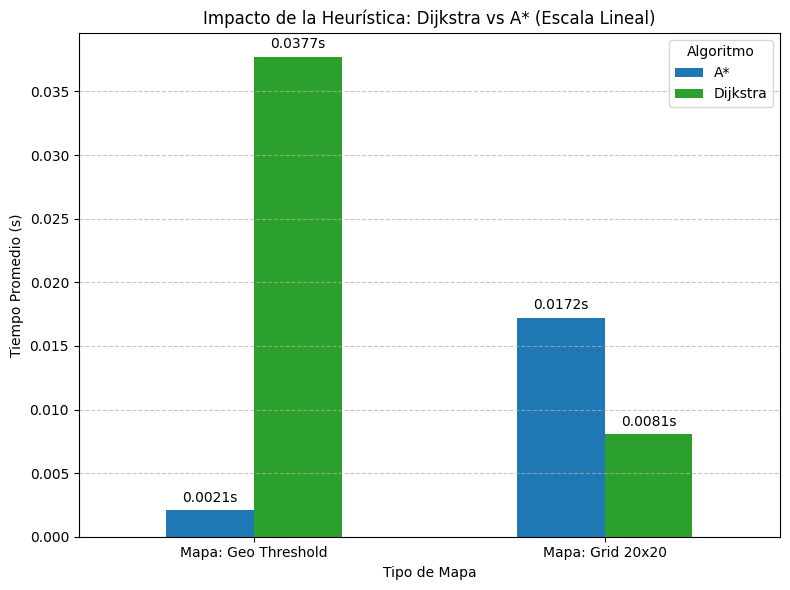

In [ ]:
def plot_dijkstra_vs_astar(df_resultados):
    """
    Genera un gráfico específico para validar la Hipótesis 2:
    Comparación directa Dijkstra vs A* solo en grafos con coordenadas.
    """
    # 1. Filtramos solo los datasets de tipo "Mapa" (Grid y Geo)
    map_df = df_resultados[df_resultados["Dataset"].str.contains("Mapa")]

    # 2. Filtramos solo los algoritmos de interés
    target_algs = ["Dijkstra", "A*"]
    map_df = map_df[map_df["Algoritmo"].isin(target_algs)]

    if map_df.empty:
        print("No hay datos de Mapas/A* para graficar.")
        return

    # 3. Preparamos el gráfico
    pivot_map = map_df.pivot(index="Dataset", columns="Algoritmo", values="Tiempo Promedio (s)")

    # Usamos escala LINEAL (normal) para ver la mejora de 1.5x o 3x
    ax = pivot_map.plot(kind='bar', figsize=(8, 6), color=['#1f77b4', '#2ca02c'])

    plt.title("Impacto de la Heurística: Dijkstra vs A* (Escala Lineal)")
    plt.ylabel("Tiempo Promedio (s)")
    plt.xlabel("Tipo de Mapa")
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Agregar etiquetas de valor encima de las barras para ver la diferencia exacta
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}s',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()

# --- Ejecutar este gráfico al final ---
plot_dijkstra_vs_astar(df_resultados)

##

##Bellman-Ford

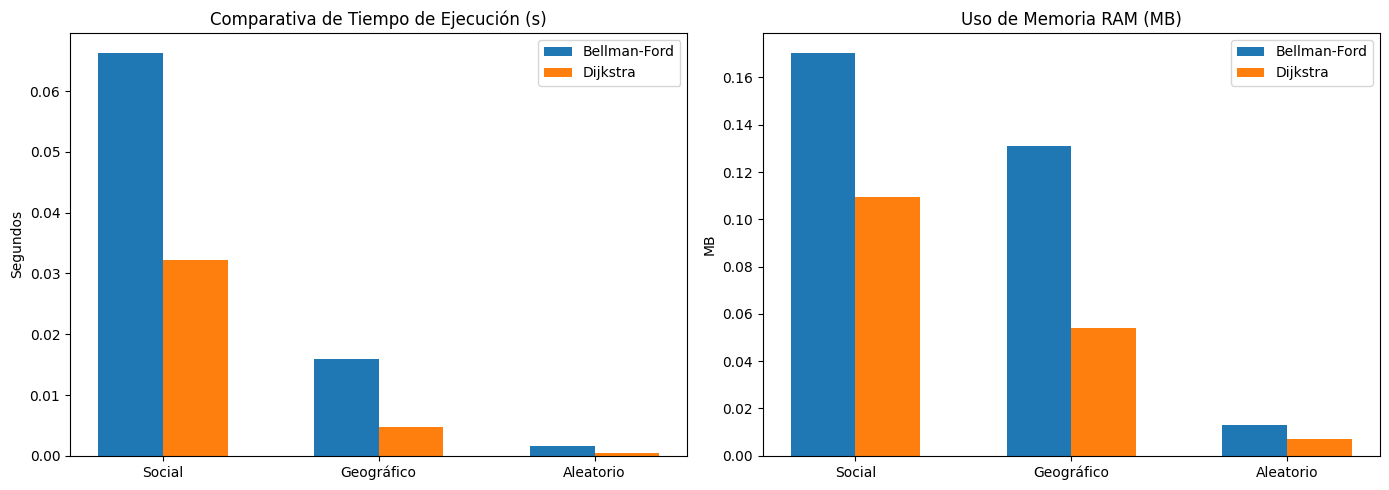

Resumen de datos promedio:
      Dataset     Algoritmo  Tiempo (s)  Memoria (MB)
0   Aleatorio  Bellman-Ford    0.066284      0.170347
1   Aleatorio      Dijkstra    0.032277      0.109552
2  Geográfico  Bellman-Ford    0.015856      0.130818
3  Geográfico      Dijkstra    0.004704      0.054224
4      Social  Bellman-Ford    0.001533      0.013189
5      Social      Dijkstra    0.000499      0.007285


In [ ]:
import networkx as nx
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tracemalloc import start, stop, get_traced_memory, start as start_trace, stop as stop_trace

# 1. Configuración de Algoritmos
def run_benchmark(G, source, target):
    results = {}

    # --- Dijkstra (HeapQ) --- [cite: 113, 169]
    start_trace()
    start_time = time.perf_counter()
    nx.dijkstra_path_length(G, source, target, weight='weight')
    end_time = time.perf_counter()
    _, peak_mem = get_traced_memory()
    stop_trace()

    results['Dijkstra'] = {
        'time': end_time - start_time,
        'memory': peak_mem / 10**6  # Convertido a MB [cite: 199]
    }

    # --- Bellman-Ford --- [cite: 118, 171]
    start_trace()
    start_time = time.perf_counter()
    nx.bellman_ford_path_length(G, source, target, weight='weight')
    end_time = time.perf_counter()
    _, peak_mem = get_traced_memory()
    stop_trace()

    results['Bellman-Ford'] = {
        'time': end_time - start_time,
        'memory': peak_mem / 10**6
    }

    return results

# 2. Generación de Datasets (Semillas fijas para reproducibilidad [cite: 206])
np.random.seed(42)
datasets = {
    "Social": nx.karate_club_graph(), #
    "Geográfico": nx.grid_2d_graph(20, 20), # [cite: 182]
    "Aleatorio": nx.erdos_renyi_graph(500, 0.1, seed=42) #
}

# Añadir pesos a las aristas (Dijkstra requiere pesos no negativos [cite: 114])
for name, G in datasets.items():
    for (u, v) in G.edges():
        G.edges[u,v]['weight'] = np.random.uniform(1.0, 10.0)

# 3. Ejecución de Pruebas (10 ejecuciones por cada una [cite: 206])
all_results = []
for name, G in datasets.items():
    nodes = list(G.nodes())
    u, v = nodes[0], nodes[-1]

    for _ in range(10):
        res = run_benchmark(G, u, v)
        for alg, metrics in res.items():
            all_results.append({
                "Dataset": name,
                "Algoritmo": alg,
                "Tiempo (s)": metrics['time'],
                "Memoria (MB)": metrics['memory']
            })

df = pd.DataFrame(all_results)
summary = df.groupby(['Dataset', 'Algoritmo']).mean().reset_index()

# 4. Visualización de Resultados [cite: 204]
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Gráfica de Tiempo
for i, alg in enumerate(summary['Algoritmo'].unique()):
    data = summary[summary['Algoritmo'] == alg]
    ax[0].bar(np.arange(len(datasets)) + i*0.3, data['Tiempo (s)'], width=0.3, label=alg)

ax[0].set_xticks(np.arange(len(datasets)) + 0.15)
ax[0].set_xticklabels(datasets.keys())
ax[0].set_title("Comparativa de Tiempo de Ejecución (s)")
ax[0].set_ylabel("Segundos")
ax[0].legend()

# Gráfica de Memoria
for i, alg in enumerate(summary['Algoritmo'].unique()):
    data = summary[summary['Algoritmo'] == alg]
    ax[1].bar(np.arange(len(datasets)) + i*0.3, data['Memoria (MB)'], width=0.3, label=alg)

ax[1].set_xticks(np.arange(len(datasets)) + 0.15)
ax[1].set_xticklabels(datasets.keys())
ax[1].set_title("Uso de Memoria RAM (MB)")
ax[1].set_ylabel("MB")
ax[1].legend()

plt.tight_layout()
plt.show()

print("Resumen de datos promedio:")
print(summary)

In [ ]:
import networkx as nx

# 1. Crear un grafo con un peso negativo (pero sin ciclo negativo)
G_neg = nx.DiGraph()
G_neg.add_edge('A', 'B', weight=5)
G_neg.add_edge('B', 'C', weight=2)
G_neg.add_edge('A', 'C', weight=10)
G_neg.add_edge('B', 'D', weight=-4) # Arista negativa
G_neg.add_edge('D', 'C', weight=1)

print("--- Caso 1: Grafo con Peso Negativo (Sin Ciclo) ---")
try:
    print(f"Dijkstra: {nx.dijkstra_path_length(G_neg, 'A', 'C', weight='weight')}")
except Exception as e:
    print(f"Dijkstra falló o dio resultado inesperado: {e}")

print(f"Bellman-Ford: {nx.bellman_ford_path_length(G_neg, 'A', 'C', weight='weight')}")

# 2. Crear un grafo con un CICLO NEGATIVO
G_ciclo = nx.DiGraph()
G_ciclo.add_edge('A', 'B', weight=1)
G_ciclo.add_edge('B', 'C', weight=-5) # Ciclo B->C->B suma -2
G_ciclo.add_edge('C', 'B', weight=3)

print("\n--- Caso 2: Grafo con Ciclo Negativo ---")
try:
    dist, path = nx.single_source_bellman_ford(G_ciclo, 'A')
    print("Bellman-Ford no detectó el ciclo (inesperado)")
except nx.NetworkXUnbounded:
    print("Bellman-Ford detectó correctamente un CICLO NEGATIVO (Error: NetworkXUnbounded)")

try:
    print(f"Dijkstra: {nx.dijkstra_path_length(G_ciclo, 'A', 'C', weight='weight')}")
    print("Nota: Dijkstra dio un resultado, pero es INCORRECTO en presencia de ciclos negativos.")
except:
    print("Dijkstra falló.")

--- Caso 1: Grafo con Peso Negativo (Sin Ciclo) ---
Dijkstra: 2
Bellman-Ford: 2

--- Caso 2: Grafo con Ciclo Negativo ---
Bellman-Ford detectó correctamente un CICLO NEGATIVO (Error: NetworkXUnbounded)
Dijkstra: -4
Nota: Dijkstra dio un resultado, pero es INCORRECTO en presencia de ciclos negativos.
